## Seeding dynamic for the kinematic driver introduced in Shipway & Hill 2012 
https://doi.org/10.1002/qj.1913

(see the Shipway and Hill example in PySDM for more details)

**NOTES**: 
- constant momentum profile rather than constant velocity profile is used herein
- enabling precipitation interpretted as turning on sedimentation and collisions
- pressure at z=0 not given in the paper, assumed (see settings.py)
- domain extended below z=0 to mimic particle inflow

In [1]:
import numpy as np
from PySDM import Formulae
from PySDM.physics import si
from PySDM_examples.seeding.settings_1d import Settings
from PySDM_examples.seeding.simulation_1d import Simulation

from PySDM.physics import in_unit, si
import matplotlib.pyplot as plt
from matplotlib import pyplot
from PySDM_examples.Shipway_and_Hill_2012 import plot
from open_atmos_jupyter_utils import show_plot

In [2]:
np.random.seed(123)

common_params = {
    "n_sd_per_gridbox": 32,
    "n_sd_seeding": 200,
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 990 * si.hPa,
    "kappa": .3,
    "particles_per_volume_STP": 50 / si.cm**3,
    "seed_particles_per_volume_STP": 50 / si.cm**3,
    "seed_kappa": .8,
}

rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s
simulations = {
    case: Simulation(
        Settings(
            **common_params,
            rho_times_w_1=rho_times_w,
            formulae= Formulae(seed= np.random.randint(1000)),
            super_droplet_injection_rate = {
                'seeding': lambda time: 3 if 5 * si.min < time < 10 * si.min else 0,
                'no seeding': lambda _: 0,
            }[case],
            precip=True,
        )
    )
    for case in ('seeding', 'no seeding')
}

/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


In [3]:
outputs = {case: simulations[case].run() for case in simulations}

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


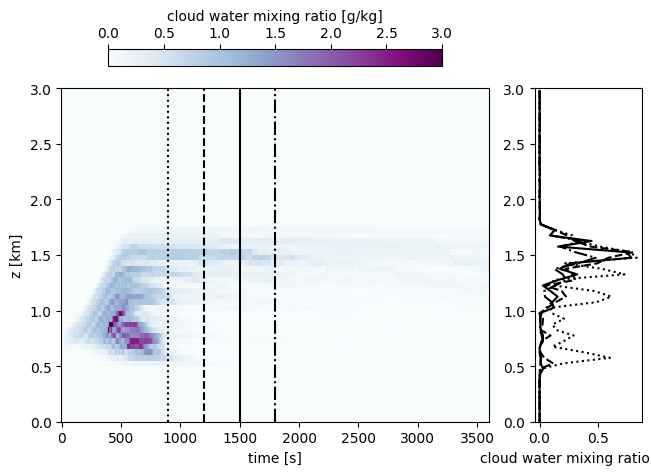

HTML(value="<a href='./qc_seeding.pdf' target='_blank'>./qc_seeding.pdf</a><br>")

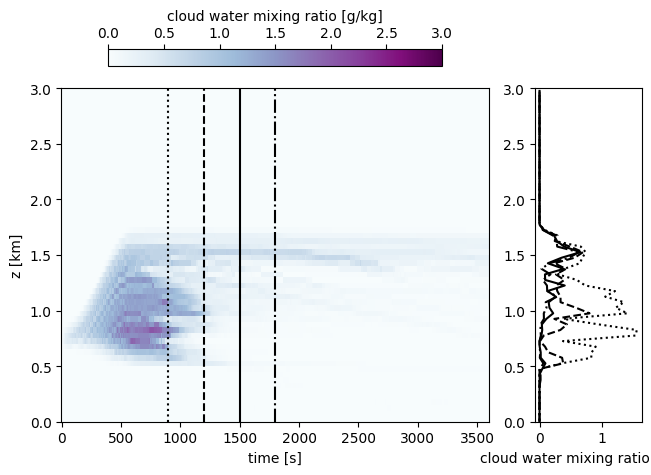

HTML(value="<a href='./qc_no seeding.pdf' target='_blank'>./qc_no seeding.pdf</a><br>")

In [4]:
for case, output in outputs.items():
    plot(var='cloud water mixing ratio', qlabel='cloud water mixing ratio [g/kg]', fname= 'qc_' + case +'.pdf', cmin= 0, cmax= 3, output= output.products)

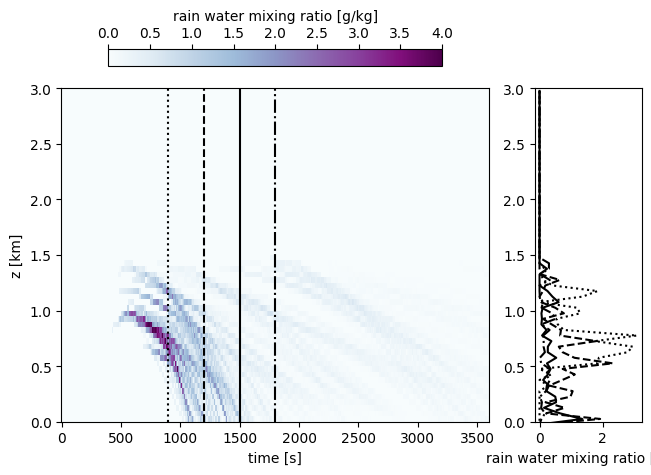

HTML(value="<a href='./qr_seeding.pdf' target='_blank'>./qr_seeding.pdf</a><br>")

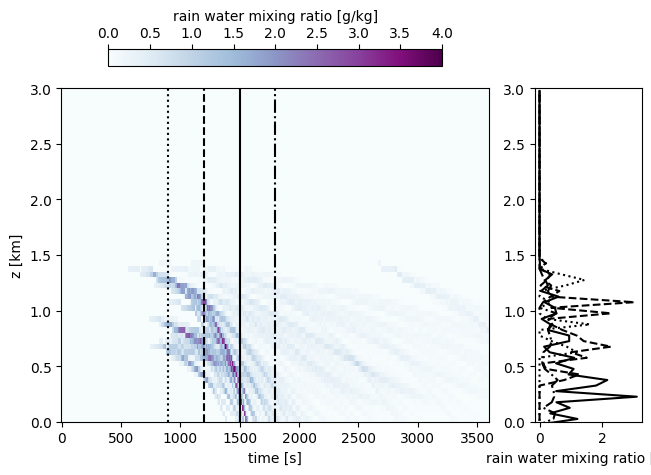

HTML(value="<a href='./qr_no seeding.pdf' target='_blank'>./qr_no seeding.pdf</a><br>")

In [5]:
for case, output in outputs.items():
    plot(var='rain water mixing ratio', qlabel='rain water mixing ratio [g/kg]', fname= 'qr_' + case +'.pdf', cmin= 0, cmax= 4, output= output.products)

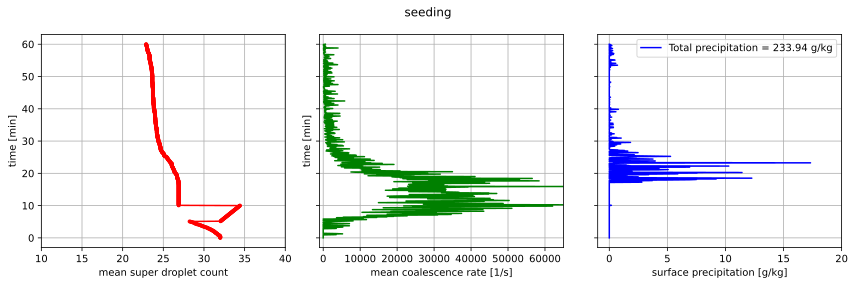

HTML(value="<a href='./SH2012_seeding.pdf' target='_blank'>./SH2012_seeding.pdf</a><br>")

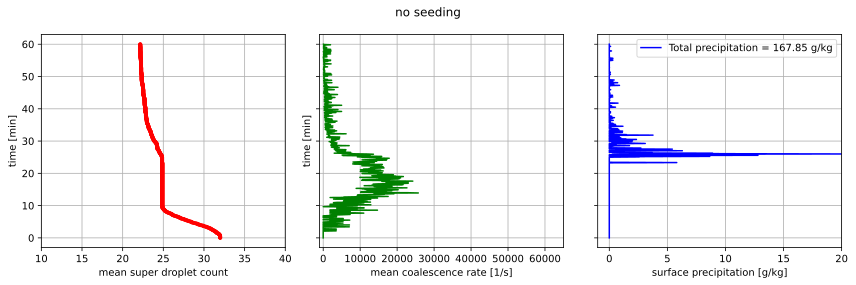

HTML(value="<a href='./SH2012_no_seeding.pdf' target='_blank'>./SH2012_no_seeding.pdf</a><br>")

In [6]:
for case, output in outputs.items():
    time = output.products['t']
    water_mass = output.products['effective radius']
    
    fig, axs = pyplot.subplot_mosaic(
        [['a', 'b', 'c']],
        sharey=True,
        figsize=(12, 4),
        tight_layout=True
    )
    axs['a'].plot(
        output.products['super droplet count per gridbox'].mean(axis= 0),
        in_unit(time, si.min),
        marker='.',
        color='red',
    )
    axs['a'].set_ylabel("time [min]")
    axs['a'].set_xlabel("mean super droplet count")
    axs['a'].grid()
    axs['a'].set_xlim(10, 40)

    axs['b'].plot(
        output.products['coalescence_rate'].mean(axis= 0),
        in_unit(time, si.min),
        color='green',
    )
    axs['b'].set_ylabel("time [min]")
    axs['b'].set_xlabel("mean coalescence rate [1/s]")
    axs['b'].grid()
    axs['b'].set_xlim(-1000, 65000)

    axs['c'].plot(
        in_unit(output.products['surface precipitation'], si.g/si.kg),
        in_unit(time, si.min),
        color='blue',
        label= r'Total precipitation = %.2f g/kg'%in_unit(output.products['surface precipitation'].sum(), si.g/si.kg)    
    )
    axs['c'].set_xlabel(f"surface precipitation [g/kg]")
    axs['c'].grid()
    axs['c'].legend(loc= 'upper right')
    axs['c'].set_xlim(-1, 20)

    fig.suptitle(case)
    show_plot(f"SH2012_{case.replace(' ', '_')}.pdf")